Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [44]:
NAMES = "Simon Passenheim, Leon Lang"

---

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [46]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [47]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

Take a moment to figure out what P represents. 
Note that this is a deterministic environment. 
What would a stochastic environment look like?

Answer: 
 - the numbers from 0 to 15 represent the states of the environment.
 - The numbers 0 to 3 for each state represent the actions that can be taken there
 - For each action, we get a list of tuples of the form (prob, next_state, reward, done)
 - The probs are always 1, since the environment is deterministic.
 - For non-deterministic environments, there would be probs unequal to 1 and the lists would contain more than one element.

In [48]:
def policy_eval(policy, env, discount_factor=1, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        error = 0 # Error will represent maximum norm of difference of old and new value function.
        for s in range(env.nS):
            new_value = 0 # new value in that state; initialization
            for a in range(env.nA):
                action_value = 0 # will be used for update of new value
                for (prob, next_state, reward, _) in env.P[s][a]:
                    action_value += prob*(reward + discount_factor*V[next_state]) 
                new_value += policy[s,a]*action_value # bellmann update for specific action
            error = max(error, abs(new_value - V[s]))
            V[s] = new_value
        if error < theta:
            break
        
    return V

In [49]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
print(V)

# As we can see, the value function estimates are close to the true values in Sutton and Barto's book.
# The true value function is the negation of the expected number of steps until the goal is reached.
# It makes sense that this is longer for the points far away from the goal corners, which is what we see in the value function.

[  0.         -13.99993529 -19.99990698 -21.99989761 -13.99993529
 -17.9999206  -19.99991379 -19.99991477 -19.99990698 -19.99991379
 -17.99992725 -13.99994569 -21.99989761 -19.99991477 -13.99994569
   0.        ]


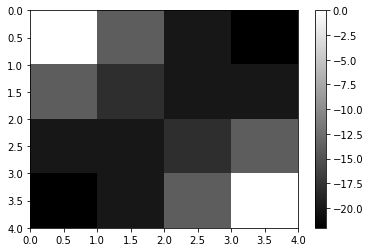

In [50]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [51]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        go_on = False # Will determine if we should break the loop
        V = policy_eval(policy, env, discount_factor)  
        for s in range(env.nS):
            action_values = np.zeros([env.nA]) # Compute all action values in order to find new best action
            for a in range(env.nA):
                action_value = 0 # specific action value
                for (prob, next_state, reward, _) in env.P[s][a]:
                    action_value += prob*(reward + discount_factor*V[next_state])
                action_values[a] = action_value
            best_action = np.argmax(action_values)
            if policy[s, best_action] != 1: # this means the policy is not optimal with respect to the current value function
                go_on = True
                policy[s] = np.eye(env.nA)[best_action]
        if go_on == False:
            break
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



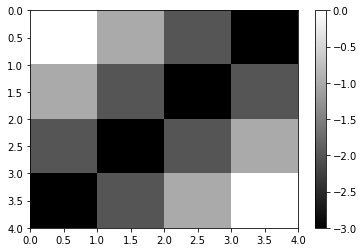

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [13]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    optimal_actions = np.zeros([env.nS])
    
    # First: Compute optimal value function while recording the optimal actions
    while True:
        error = 0 # max-norm of difference of old and new value function
        for s in range(env.nS):
            # Update value V[s]
            new_value = 0
            action_values = np.zeros([env.nA])
            for a in range(env.nA):
                # Compute action value. Update state value then with best action value.
                action_value = 0
                for (prob, next_state, reward, _) in env.P[s][a]:
                    action_value += prob*(reward + discount_factor*V[next_state])
                action_values[a] = action_value
            new_value = np.max(action_values)
            optimal_actions[s] = np.argmax(action_values)
            error = max(error, abs(new_value - V[s]))
            V[s] = new_value
        if error < theta:
            break
    
    # Second: After Optimal value function is computed, compute optimal policy
    for s in range(env.nS):
        policy[s] = np.eye(env.nA)[int(optimal_actions[s])]
    
    
    return policy, V

In [14]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Answer: Policy iteration performs a full policy evaluation step after each policy improvement. In contrast, value iteration can be interpreted as only making a single evaluation update after each improvement of the policy. 

Mathematically, it turns out that this can even be done without considering the policy at all, i.e. value iteration directly finds the optimal value function and afterwards computes the optimal policy based on this. This works by making updates using the Bellman optimality equation instead of the usual Bellman equation. As shown in Exercise 4 of the written homework, updates with the Bellman optimality equation necessarily converge to a unique solution. All in all, value iteration is clearly more efficient.

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

They differ both in depth and breadth: Dynamic programming makes a depth-1 update, but over the complete action space. On the other hand, Monte Carlo methods make updates until for complete runs, but only considering the specific current trajectory of the agent, neglecting counterfactuals.

Dynamic programming can be used in smaller state spaces when the dynamics of the environment are completely known. In contrast, Monte Carlo methods can be used in larger state spaces with unknown dynamics, since updates for Monte Carlo work by sampling trajectories.

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [15]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [16]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [17]:
# We can also look at the documentation/implementation of a method
?env.step

In [18]:
# resets state of environment, creates new observation
?env.reset

In [19]:
# Creates image of the current state, probably
?env.render

In [40]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [21]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    if observation[0] >= 20:
        action = 0 # stick
    else:
        action = 1 # hit
    return action

In [22]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(20, 1, False)
((20, 1, False), 1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [23]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling. I do every visit MC!
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple (in black jack: (sum, card of dealer, usable one)) and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(num_episodes):
        
        # generate episode
        env.reset()
        observation = env._get_obs()
        observations = [observation]
        rewards = []
        while True: # stops if done is True, i.e. episode ends
            action = policy(observation)
            observation, reward, done, _ = env.step(action)
            rewards.append(reward)
            observations.append(observation)
            if done:
                break
        
        # Update all values of visited states using returns!
        T = len(rewards)
        G = 0
        for i in range(T):
            t = (T-1)-i  # So T = T-1, T-2, ..., 0
            G = discount_factor*G + rewards[t] # in Sutton: rewards[t+1]. Have an index shift since our lists start with 0!
            if observations[t] in returns_sum:
                returns_sum[observations[t]] += G
                returns_count[observations[t]] += 1
            else:
                returns_sum[observations[t]] = G
                returns_count[observations[t]] = 1
            V[observations[t]] = returns_sum[observations[t]] / returns_count[observations[t]]     
    
    return V

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [24]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

CPU times: user 43.6 s, sys: 16.2 ms, total: 43.6 s
Wall time: 43.6 s


10k, usable ace


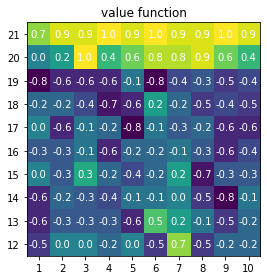

500k, usable ace


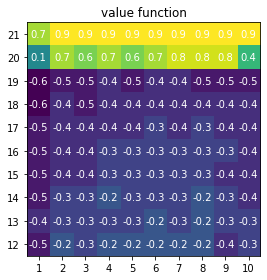

10k, no usable ace


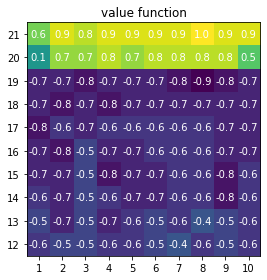

500k, no usable ace


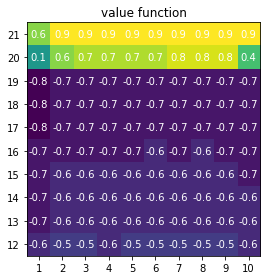

In [41]:
# Cell with plots
def plot_value_function(V=V_10k, usable_ace=False, value_function=True):
    """
    Plots the value function for black jack.
    
    Args:
        V: the value function used (V_10k or V_500k)
        usable_ace: Whether we plot for the situation with a usable ace or not
        value_function: whether what's put in is a value function. We need that since later we also want to plot policies!
    
    Returns: nothing, but plots something.
    """
    """
    plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.show()
    """
    
    data = np.zeros([10, 10])
    for i in range(10):
        for j in range(10):
            if value_function:
                data[i,j] = round(V[(21-i, j+1, usable_ace)], 1)
            else:
                # In this case: V is a policy! (Sorry for weird notation)
                data[i,j] = np.argmax(V((21-i, j+1, usable_ace))[1]) # Just put action, 0 or 1, directly in threre!
    fig, ax = plt.subplots()
    im = ax.imshow(data)

    # We want to show all ticks...
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    
    ax.set_xticklabels(range(1, 11))
    l = list(range(12, 22))
    l.reverse()
    ax.set_yticklabels(l)

    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("value function")
    fig.tight_layout()
    plt.show()
    plt.close()

print("10k, usable ace")
plot_value_function(V_10k, True)
print("500k, usable ace")
plot_value_function(V_500k, True)
print("10k, no usable ace")
plot_value_function(V_10k, False)
print("500k, no usable ace")
plot_value_function(V_500k, False)

    


## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [26]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        an action according to the epsilon-greedy policy.
    
    """
    def policy_fn(observation):
        
        action_values = Q[observation]
        best_action = np.argmax(action_values)
        probs = np.array([epsilon]*nA)/nA
        probs[best_action] = 1 - epsilon + epsilon/nA
        action = np.random.choice(nA, 1, p=probs).item()
        
        return action, probs
        
    return policy_fn

In [27]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    for i in range(num_episodes):
        # (Update) the policy we're following.
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)


        # generate episode
        env.reset()
        observation = env._get_obs()
        observations = [observation]
        actions = []
        rewards = []

        while True: # stops if "done" is True, i.e. episode ends
            action, _ = policy(observation)
            observation, reward, done, _ = env.step(action)
            actions.append(action)
            rewards.append(reward)
            if done:
                break # Break before last observation gets appended.
            observations.append(observation)


        # Update all values of visited state-action pairs
        T = len(rewards)
        G = 0
        for i in range(T):
            t = (T-1)-i  # So T = T-1, T-2, ..., 0
            G = discount_factor*G + rewards[t] # in Sutton: rewards[t+1]. Have an index shift since our lists start with 0!
            
            returns_sum[observations[t]][actions[t]] += G
            returns_count[observations[t]][actions[t]] += 1
                        
            Q[observations[t]][actions[t]] = returns_sum[observations[t]][actions[t]] / returns_count[observations[t]][actions[t]]
        
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

In [28]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

CPU times: user 1min 25s, sys: 28.1 ms, total: 1min 25s
Wall time: 1min 25s


In [32]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=5000000, epsilon=0.1)

CPU times: user 14min 8s, sys: 120 ms, total: 14min 8s
Wall time: 14min 8s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

Answer: The $V$-value function emerges from the $Q$-value function as a weighted average according to the action-selection-probabilities. That is, for all states $s \in S$ we have:

$$V(s) = \sum_{a \in A} \pi(a \mid s) Q(s, a).$$

While we saw that we cannot get the $Q$-value function from the $V$-value function without knowing the dynamics of the environment, we can in fact do the opposite. This is since here we don't need the dynamics of the environment, but the "dynamics of the agent", so to speak.

5000k, usable ace


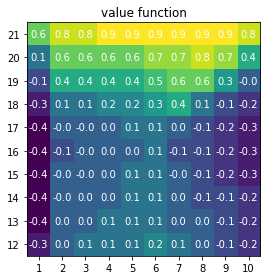

5000k, no usable ace


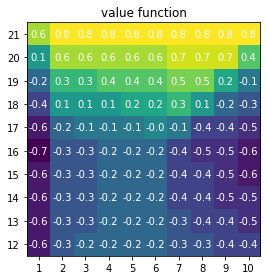

5000k, greedy policy, usable ace


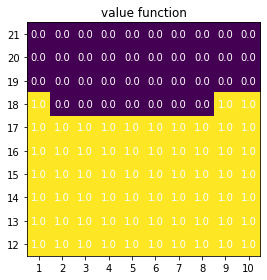

5000k, greedy policy, no usable ace


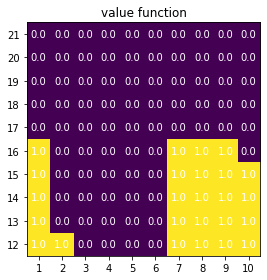

In [42]:
V = defaultdict(float)

for observation in Q.keys():
    V[observation] = 0
    _, probs = policy(observation)
    for action in range(len(Q[observation])):
        prob = probs[action]
        V[observation] += prob * Q[observation][action]
   
print("5000k, usable ace")
plot_value_function(V, True)
print("5000k, no usable ace")
plot_value_function(V, False)

print("5000k, greedy policy, usable ace")
plot_value_function(policy, True, value_function=False)
print("5000k, greedy policy, no usable ace")
plot_value_function(policy, False, value_function=False)